In [18]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2  as Sampler
from qiskit.circuit.library import ZGate, MCXGate
from qiskit.quantum_info import Statevector
import random

In [ ]:
n = 8 # numero di qubit (cerca in 2^n elementi)
assert 2 <= n <= 19, "n deve essere almeno 2 per Grover e meno di 19 (per evitare calcoli troppo lunghi)."
secret = random.randint(0, 2**n - 1)
print(f"✅ La funzione f(x) restituisce 1 solo per x = {secret:0{n}b} (non lo conosciamo!)")

✅ La funzione f(x) restituisce 1 solo per x = 11000000 (non lo conosciamo!)


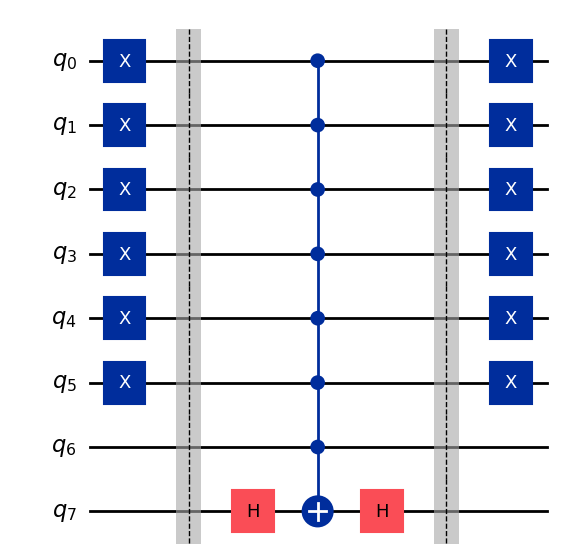

In [20]:
oracle = QuantumCircuit(n)
target_bits = f"{secret:0{n}b}"

for i, bit in enumerate(reversed(target_bits)):
    if bit == '0':
        oracle.x(i)

oracle.barrier()

oracle.h(n-1)
oracle.mcx(list(range(n-1)), n-1)
oracle.h(n-1)

oracle.barrier()

for i, bit in enumerate(reversed(target_bits)):
    if bit == '0':
        oracle.x(i)

oracle.name = "Oracle"
oracle.draw('mpl')

In [21]:
def diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    qc.name = "Diffuser"
    return qc

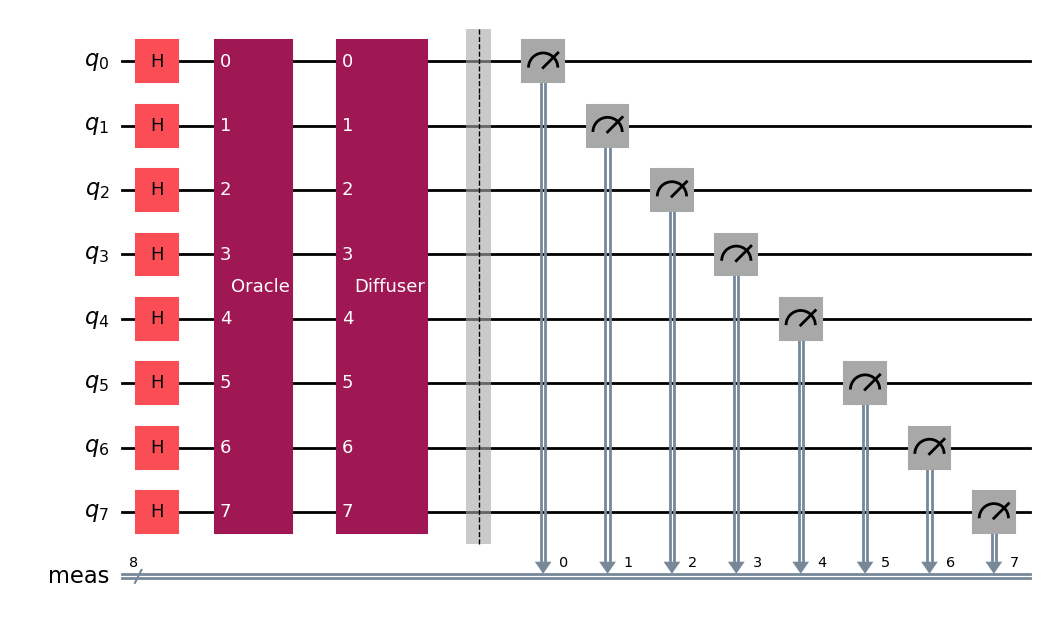

In [22]:
qc = QuantumCircuit(n)

qc.h(range(n))

qc.append(oracle, range(n))
qc.append(diffuser(n), range(n))

qc.measure_all()

qc.draw('mpl')

In [23]:
backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_isa = pm.run([qc])

sampler = Sampler(mode=backend)
job = sampler.run(qc_isa, shots=max(1024, 2**(n+2)))
res = job.result()

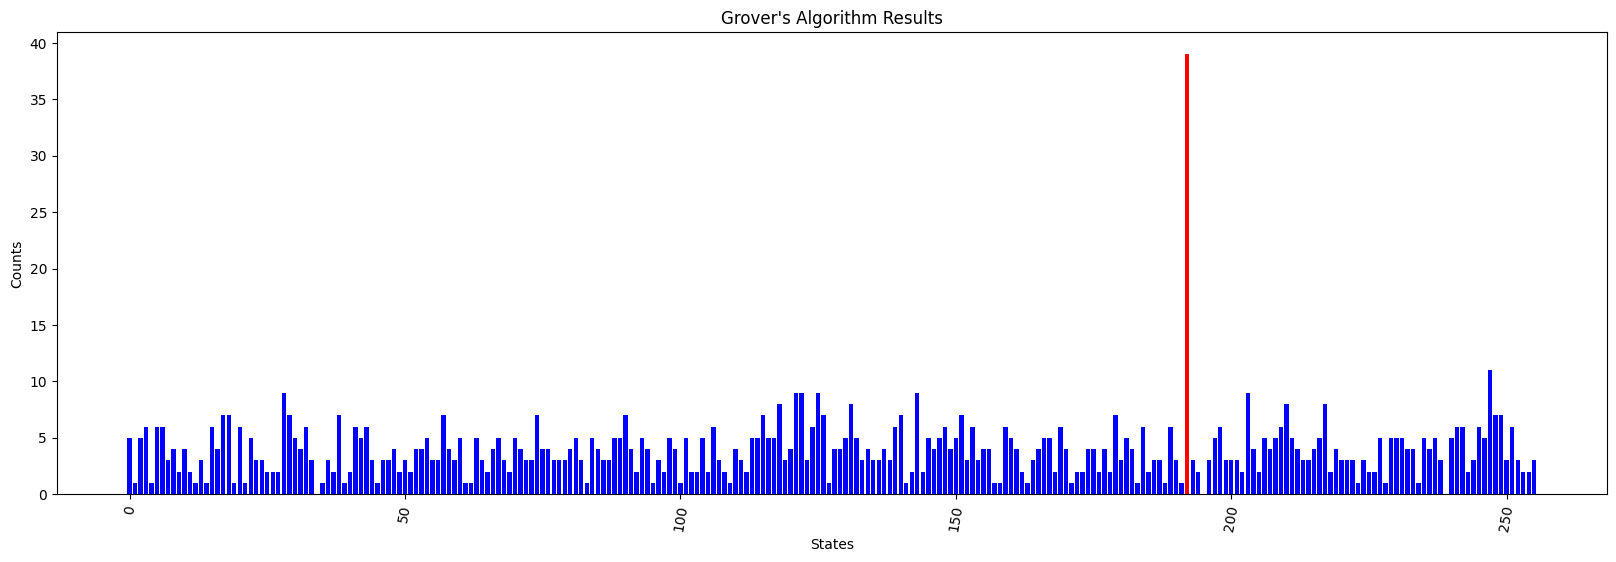

In [24]:
import matplotlib.pyplot as plt

countz = res[0].data.meas.get_counts()
secret_key = f"{secret:0{n}b}"
if n <= 10:
    # in histogram color of red the column of secret, blue the others
    labels = [bin(i)[2:].zfill(n) for i in range(2**n)]
    counts = [countz[k] if k in countz else 0 for k in labels]
    colors = ['red' if k == secret_key else 'blue' for k in labels]
    plt.figure(figsize=(20, 6))
    if n <= 6:
        plt.bar(labels, counts, color=colors)
        for i, (label, value) in enumerate(zip(labels, counts)):
            plt.text(i, int(value) + max(9 - n, 3), value, ha='center')
    else:
        plt.bar(range(len(labels)), counts, color=colors)
    plt.xlabel('States')
    plt.ylabel('Counts')
    plt.title('Grover\'s Algorithm Results')
    plt.xticks(rotation=80)
    plt.show()

In [25]:
# order by values
sorted_counts = sorted(countz.items(), key=lambda x: x[1], reverse=True)
print("Counts sorted by frequency:")
for state, count in sorted_counts[:10]:
    print(f"{state}: {count}")

print('--------------------------------------------')

print(secret_key, ': ', countz[secret_key] if secret_key in countz else 0, sep='')

Counts sorted by frequency:
11000000: 39
11110111: 11
01111010: 9
10001111: 9
00011100: 9
01111101: 9
01111001: 9
11001011: 9
11010010: 8
11011001: 8
--------------------------------------------
11000000: 39


### Hashing example

Diffuser:


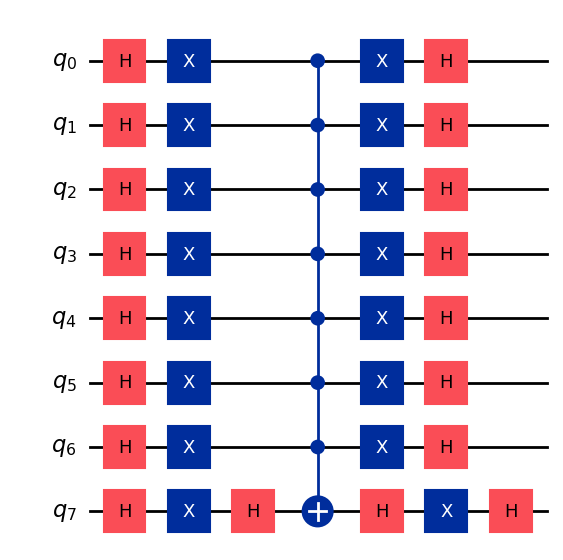

In [90]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2  as Sampler
from qiskit.circuit.library import ZGate, MCXGate
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# Target value we want to invert in the oracle
target = 0  # Suppose toy_hash(x) == 0

BITS = 8
N = 2**BITS

hash_function = lambda x: (x * 3 + 1) % N  # Example hash function

# Build the oracle: flips the sign of |x⟩ if toy_hash(x) == target
def grover_oracle():
    oracle = QuantumCircuit(BITS, name='Oracle')
    for x in range(256):
        if hash_function(x) == target:
            bin_x = format(x, f'0{BITS}b')
            for i, bit in enumerate(reversed(bin_x)):
                if bit == '0':
                    oracle.x(i)
            oracle.h(BITS-1)  # Apply multi-controlled-Z via H-CZ-H
            oracle.mcx([i for i in range(BITS-1)], BITS-1)  # Multi-controlled Toffoli
            oracle.h(BITS-1)  # Undo the H
            for i, bit in enumerate(reversed(bin_x)):
                if bit == '0':
                    oracle.x(i)
            break  # only one solution
    return oracle

# Diffusion (inversion about mean)
def diffusion_operator():
    diffuser = QuantumCircuit(BITS, name='Diffuser')
    diffuser.h([i for i in range(BITS)])
    diffuser.x([i for i in range(BITS)])
    diffuser.h(BITS-1)
    diffuser.mcx([i for i in range(BITS-1)], BITS-1)  # Multi-controlled Toffoli
    diffuser.h(BITS-1)
    diffuser.x([i for i in range(BITS)])
    diffuser.h([i for i in range(BITS)])
    return diffuser

# Build Grover circuit
grover = QuantumCircuit(BITS)
grover.h([i for i in range(BITS)])  # Start in superposition

# Add one iteration of Grover
oracle = grover_oracle()
grover.append(oracle.to_gate(), [i for i in range(BITS)])
diffuser = diffusion_operator()
grover.append(diffuser.to_gate(), [i for i in range(BITS)])

# Measurement
grover.measure_all()

print('Diffuser:')
diffuser.draw('mpl')

Oracle:


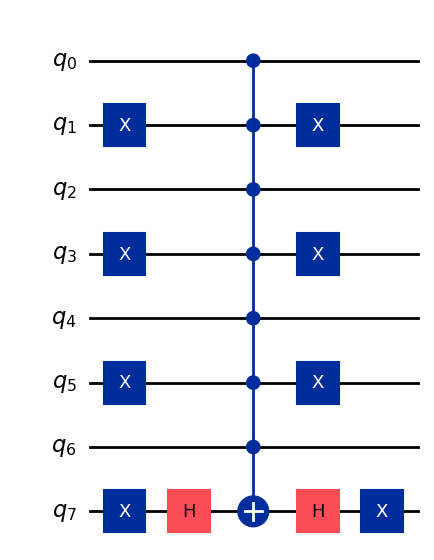

In [91]:
print('Oracle:')
oracle.draw('mpl')

Entire circuit:


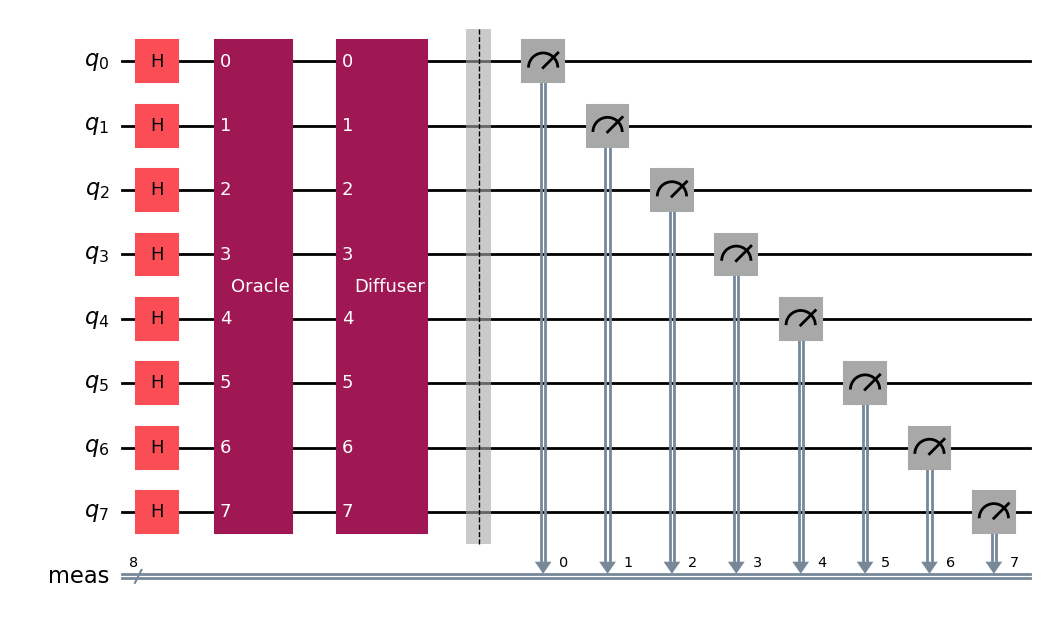

In [92]:
print('Entire circuit:')
grover.draw('mpl')

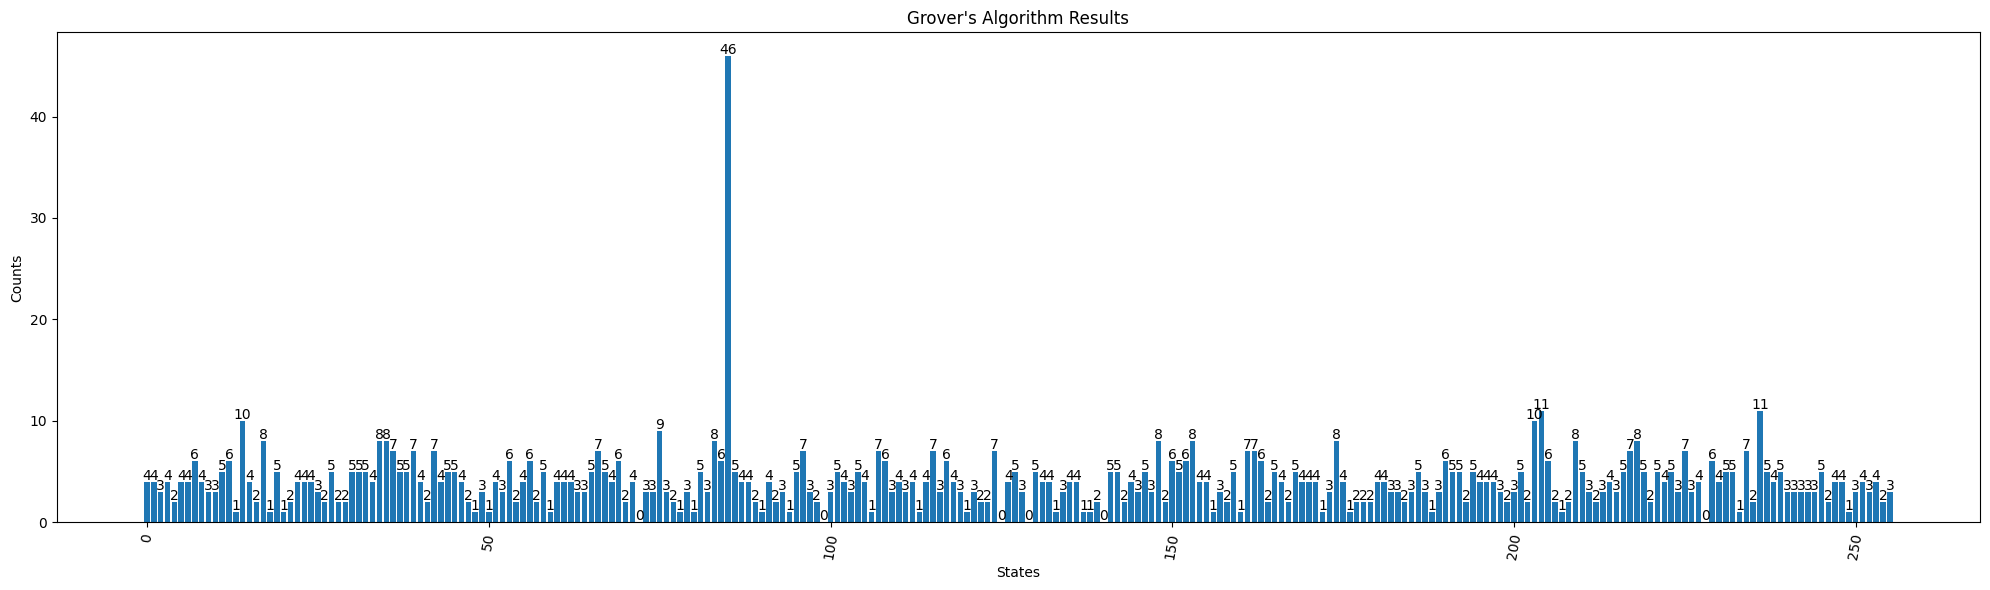

Counts sorted by frequency:
Target: 0
01010101 -> 85		frequence: 46		hash: 0
11101100 -> 236		frequence: 11		hash: 197
11001100 -> 204		frequence: 11		hash: 101
11001011 -> 203		frequence: 10		hash: 98
00001110 -> 14		frequence: 10		hash: 43
01001011 -> 75		frequence: 9		hash: 226
10010100 -> 148		frequence: 8		hash: 189
00100010 -> 34		frequence: 8		hash: 103
11010001 -> 209		frequence: 8		hash: 116
10011001 -> 153		frequence: 8		hash: 204


In [93]:
backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_isa = pm.run([grover])
sampler = Sampler(mode=backend)
job = sampler.run(qc_isa, shots=1024)
res = job.result()
counts = res[0].data.meas.get_counts()
counts_int = [0 for _ in range(2**BITS)]
for k, v in counts.items():
    counts_int[int(k, base=2)] = int(v)
plt.figure(figsize=(20, 6))
plt.bar([i for i in range(N)], counts_int)
plt.xlabel('States')
plt.ylabel('Counts')
plt.title('Grover\'s Algorithm Results')
plt.xticks(rotation=80)
plt.tight_layout()
for i, value in enumerate(counts_int):
    plt.text(i, value + 0.2, value, ha='center')
plt.show()
print('Counts sorted by frequency:')
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
print(f"Target: {target}")
for state, count in sorted_counts[:10]:
    print(f"{state} -> {int(state, 2)}\t\tfrequence: {count}\t\thash: {hash_function(int(state, 2))}")
